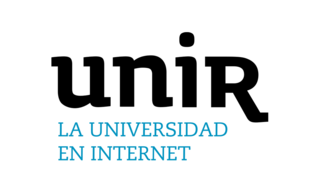

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



In [2]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 13.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 34.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.1 MB/s eta 0:00:00 0:00:01
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11428 sha256=7a1c0c198fcd5b6d325211ca045f7e490a1f57d14f4fd405ac819d3c8488574e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filen

In [3]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.2.2
Lightkurve: 2.5.0


| Fuente       | Misión | Etiquetado | Tipo         | Método de acceso                   |
| ------------ | ------ | ---------- | ------------ | ---------------------------------- |
| Kepler EB    | Kepler | Sí         | Binaries     | NASA Exoplanet Archive / Villanova |
| K2VARCAT     | K2     | Sí         | Multiclase   | MAST HLSP                          |
| TESS-SVC     | TESS   | Semi       | Variabilidad | MAST HLSP                          |
| TESS-EB      | TESS   | Sí         | EB continuas | MAST HLSP                          |
| VSX (AAVSO)  | Todos  | Sí         | Multiclase   | AAVSO + MAST                       |
| Gaia DR3 Var | Todos  | Sí         | Multiclase   | ESA Gaia Archive                   |

Diseño del esquema del dataset. Vamos a unificar las curvas descargadas en un dataset estructurado tipo CSV/Parquet con este esquema mínimo:

| id\_mision | id\_objeto | mision | clase\_variable | fecha\_inicio | fecha\_fin | tiempo | magnitud | error | origen\_etiqueta |
| ---------- | ---------- | ------ | --------------- | ------------- | ---------- | ------ | -------- | ----- | ---------------- |

Estrategia de implementación técnica
Podemos hacerlo en varias etapas:

- Script 1: descarga de curvas etiquetadas de Kepler EB y TESS-EB (usando ID + clase desde CSV original)
- Script 2: procesamiento de K2VARCAT (CSV disponible con clase + ID)
- Script 3: combinación cruzada entre TIC (TESS Input Catalog) y VSX (requiere posiciones celestes + nombre)
- Script 4: cruce de Gaia DR3 variables con coordenadas de Kepler/K2/TESS
- Script 5: exportación consolidada en formato CSV/Parquet final con clases normalizadas

# 📥 Descarga y consolidación de curvas EB (entorno local o SageMaker)
Esta sección permite ejecutar el script `script_1_eb.py`, ya sea con el catálogo completo (en SageMaker) o con una muestra reducida (en local), y verificar el resultado consolidado.


# 📥 Comprobación del fichero de curvas mergeado y consolidado

In [1]:
import warnings
import os, sys, platform
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librerías externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("🔇 Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_1_eb.py

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_1_eb import main as run_script_1

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

existing = len(glob.glob("/home/ec2-user/backup/data/raw/kepler/*.csv")) + len(glob.glob("/home/ec2-user/backup/data/raw/tess/*.csv"))
print(f"🗃️ Curvas ya existentes en disco: {existing}", flush=True)

# Ejecutar con la opción adecuada
if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    # Solo Kepler, solo pendientes
    run_script_1(mission="Kepler", only_pending=True)
    # Ambos, solo pendientes
    #run_script_1(mission="ALL", only_pending=True)
else:
    print("💻 Ejecutando en entorno local → catálogo de prueba")
    run_script_1(use_sample=True)

🔇 Warnings silenciados: UserWarning, FutureWarning
📁 Usando RAW_DIR: /home/ec2-user/backup/data/raw


[05/16/25 11:50:07] INFO     Found credentials from IAM Role:                                   ]8;id=329048;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=354539;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
🗃️ Curvas ya existentes en disco: 7707
🔁 Ejecutando en SageMaker → catálogo completo
[⬇] Descargando catálogos completos de Kepler y TESS...
[⬇] Descargando catálogo Kepler EB...
[📂] Cargando catálogo Kepler EB desde copia local...
[⬇] Descargando catálogo TESS EB...
[⬇] Generando CSV de entrada para descarga de curvas...
📝 CSV generado con 0 estrellas → data/lists/eb_ids.csv
[⬇] Descargando curvas de luz...

🚀 Procesando misión: Kepler (only_pending=True)
📝 CSV generado con 0 estrellas → data/lists/eb_ids_kepler_pendientes.csv
[⬇] Descargando 0 curvas en paralelo con 8 hilos...


🚀 Descargando curvas: 0it [00:00, ?it/s]


	📦 0 objetos procesados hasta ahora...
[✓] Descarga finalizada: 0 objetos procesados.
[⭢] Leyendo y fusionando curvas descargadas...


[📁] Usando 37 lotes ya existentes en /home/ec2-user/temp_batches
[⏳] Uniendo todos los lotes en /home/ec2-user/backup/processed/dataset_eb_kepler.parquet...


📚 Uniendo lotes: 100%|██████████| 37/37 [01:46<00:00,  2.88s/it]


[✅] Dataset parquet construido → /home/ec2-user/backup/processed/dataset_eb_kepler.parquet
🧹 Carpeta temporal eliminada: /home/ec2-user/temp_batches
[⭢] Fusionando metadatos (etiquetas)...
[⏱] Tiempo total: 108.39 segundos


In [ ]:
# Cargar y explorar el fichero parquet comprimido

import pandas as pd
from pathlib import Path
from IPython.display import display

parquet_path = Path("/home/ec2-user/backup/processed/dataset_eb_tess.parquet")

if parquet_path.exists():
    df = pd.read_parquet(parquet_path, engine="pyarrow", columns=["id_objeto", "clase_variable"])
    df_sample = df.head(1000)

    print("[✓] Muestra cargada correctamente:")
    display(df_sample.head())

    n_estrellas = df_sample["id_objeto"].nunique()
    print(f"[✓] Estrellas en la muestra: {n_estrellas}")
    print("\n[✓] Recuento por clase_variable:")
    print(df_sample["clase_variable"].value_counts())
else:
    print("⚠️ Archivo descomprimido no encontrado.")

In [ ]:
from src.utils.cleanup_raw import cleanup_raw_data

# Limpiar los datos de prueba
#cleanup_raw_data('/home/ec2-user/backup/data/raw', confirm=True)